# Part 1:Setup & Data Gathering

In [1]:
#!pip install lightkurve

In [2]:
# Standard libraries (done)
import pandas as pd
import numpy as np
# import pyspark

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate

# ML Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier)
import scipy

# Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

# Visualization libraries (done)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# Lightkurve package (done)
import lightkurve as lk
from lightkurve import KeplerTargetPixelFile

import warnings #(done)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/cumulative_2020.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Columns: 141 entries, rowid to koi_dikco_msky_err
dtypes: float64(117), int64(7), object(17)
memory usage: 10.3+ MB


In [4]:
df.shape

(9564, 141)

In [5]:
df.head()

,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,K00753.01,NaN,CANDIDATE,Done,2018-08-16,CANDIDATE,0.000,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,Done,2018-08-16,FALSE POSITIVE,0.000,0,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [6]:
'''
I need flux values for each star. With this purpose, I use lightcurve library to
extract time-series flux data via kepid feature. I just need kepid column
in this stage. Therefore, I'm creating a new reduced dataframe.
'''
exo = pd.read_csv('data/cumulative_2020.csv', usecols=['kepid', 'koi_disposition'])
exo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kepid            9564 non-null   int64 
 1   koi_disposition  9564 non-null   object
dtypes: int64(1), object(1)
memory usage: 149.6+ KB


In [7]:
exo.head()

,kepid,koi_disposition
0,10797460,CONFIRMED
1,10797460,CONFIRMED
2,10811496,CANDIDATE
3,10848459,FALSE POSITIVE
4,10854555,CONFIRMED


In [8]:
exo['koi_disposition'].value_counts()

FALSE POSITIVE    4839
CONFIRMED         2668
CANDIDATE         2057
Name: koi_disposition, dtype: int64

### Gathering flux data via lightcurve package 

In [9]:
# list of kepler ids
id_list = []
length = exo.kepid.size
for i in range(length):
    id_list.append(exo['kepid'][i])

In [10]:
# encoding target values
# confirmed & candidate is 1 and false positive is 0
for i in range(length):
    if(exo['koi_disposition'][i] == 'FALSE POSITIVE'):
        exo['koi_disposition'][i] = 0
    else:
        exo['koi_disposition'][i] = 1

In [11]:
def TFsinglestarpipe(kepid):
    try:
        tpf = KeplerTargetPixelFile.from_archive(kepid, quarter = 1) #collecting pixel files of star: kepid
        lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask) # converting pixelfiles to light curve
        flat, trend = lc.flatten(window_length=301, return_trend=True) #to give a more uniform curve
        df = flat.to_pandas()

        df['KeplerID'] = kepid
        df = df.drop(columns = ['time', 
                        'flux_err', 
                        'quality', 
                        'centroid_row', 
                        'centroid_col',
                        'KeplerID'], axis=1)
    
        df = df.reset_index(drop=True)
        df.index.names = [kepid]
        flux = df['flux']
        array = list(flux)
        return array
    except:
        return None

In [21]:
flux_list = []
target_list = []

for i in range(length):
    if TFsinglestarpipe(id_list[i]):
        flux_list.append(TFsinglestarpipe(id_list[i]))
        target_list.append(exo['koi_disposition'][i])
    else:
        pass

flux = np.array(flux_list)
targets = np.array(target_list)

In [22]:
flux_list

[]

In [23]:
# Saving all arrays
np.save('flux_list', flux_list)
np.save('target_list', target_list)

In [24]:
np.save('fluxes', flux)
np.save('targets', targets)

### Load all the arrays and transform them to pandas DataFrame 

In [25]:
flux_data = np.load('flux_list.npy').astype('float32')
targets = np.load('target_list.npy')

In [26]:
df_flux = pd.DataFrame(data = flux_data)
df_target = pd.DataFrame(data = targets, columns=['Disposition'])
df = pd.merge(df_target, df_flux, right_index=True, left_index=True)

In [27]:
df.head()

,Disposition,0


Disposition is the status of star has whether exoplanet or not. The other columns are flux values of the star on a time-series basis. These values are normalized due to TFsinglestarpipe function. 

In [7]:
df.describe()

,Disposition,0,1,2,3,4,5,6,7,8,...,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,...,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,0.516734,1.000024,1.000076,1.000123,1.000151,1.000075,1.000070,1.000128,1.000162,1.000215,...,0.999961,0.999885,0.999854,0.999945,1.000005,1.000160,1.000218,1.000297,1.000299,1.000302
std,0.499752,0.012480,0.011888,0.011357,0.010860,0.010379,0.009962,0.009689,0.008787,0.008353,...,0.013473,0.014931,0.015560,0.014609,0.013655,0.012954,0.012491,0.012907,0.013862,0.014470
min,0.000000,0.566598,0.412163,0.339684,0.379183,0.509427,0.693134,0.663685,0.720203,0.677743,...,0.506286,0.424078,0.408915,0.474049,0.531789,0.508052,0.491430,0.470383,0.438482,0.399503
25%,0.000000,0.999746,0.999761,0.999758,0.999762,0.999753,0.999757,0.999749,0.999748,0.999762,...,0.999801,0.999784,0.999796,0.999763,0.999698,0.999791,0.999735,0.999786,0.999755,0.999720
50%,1.000000,1.000029,1.000014,1.000012,1.000048,0.999988,1.000009,1.000020,0.999993,1.000011,...,1.000042,1.000036,1.000024,1.000002,0.999976,1.000026,0.999999,1.000035,1.000009,1.000001
75%,1.000000,1.000325,1.000296,1.000298,1.000354,1.000258,1.000278,1.000303,1.000270,1.000301,...,1.000335,1.000336,1.000281,1.000260,1.000251,1.000285,1.000300,1.000325,1.000295,1.000294
max,1.000000,1.136500,1.136092,1.135280,1.134780,1.133900,1.133026,1.132730,1.131152,1.129966,...,1.288231,1.299183,1.311326,1.323408,1.334879,1.347294,1.360644,1.374446,1.388226,1.401710


# Part 2: EDA - Visualization

### Demonstration of Lightkurve package

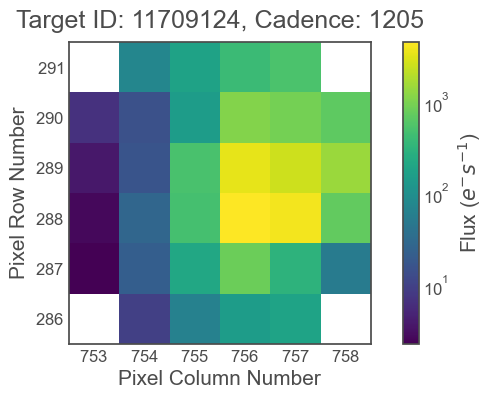

In [24]:
# displaying the signal of a star with 11709124 Kepler id
tpf = lk.search_targetpixelfile('11709124', quarter=1).download()
tpf.plot(frame=100, scale='log', show_colorbar=True)

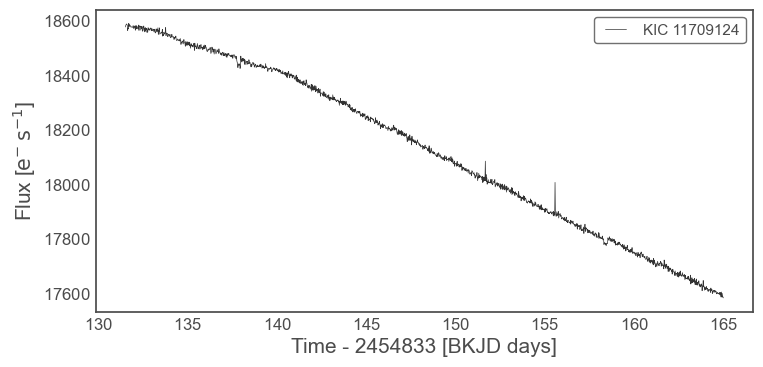

In [25]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

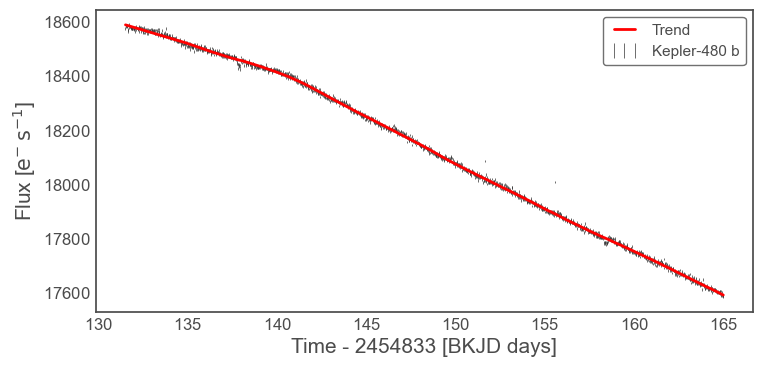

In [26]:
# flatten method removes long-term variability
flat, trend = lc.flatten(window_length=301, return_trend=True)
ax = lc.errorbar(label="Kepler-154 b")                   # plot() returns a matplotlib axes ...
trend.plot(ax=ax, color='red', lw=2, label='Trend')  # which we can pass to the next plot() to use the same axes

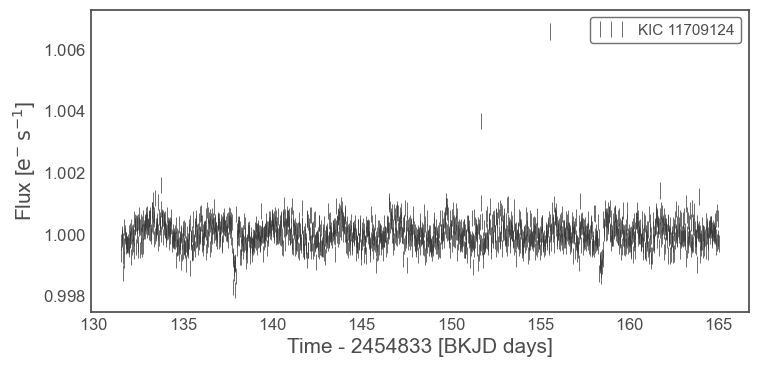

In [27]:
# flatten-normalized light curves
flat.errorbar()

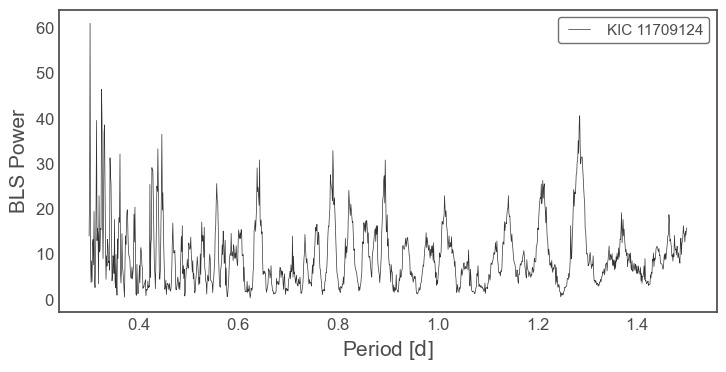

In [28]:
# BLS algorithm to search a pre-defined grid of transit periods
# periodogram is a frequency_graph to show possible repetitive patterns in the graph
# and tells which value is most likely to be periodic

periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 1.5, 0.001))
periodogram.plot();

In [29]:
best_fit_period = periodogram.period_at_max_power 
print('Best fit period: {:.3f}'.format(best_fit_period))

Best fit period: 0.302 d


In [8]:
# all the periodic changes are stacked(folded) with a specific period of that planet to revolve around that star
#it shows the trend how a planet passes infront of a star as the luminosity of star varies
flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar()

NameError: name 'flat' is not defined

### Exoplanets & Non-Exoplanets flux distributions

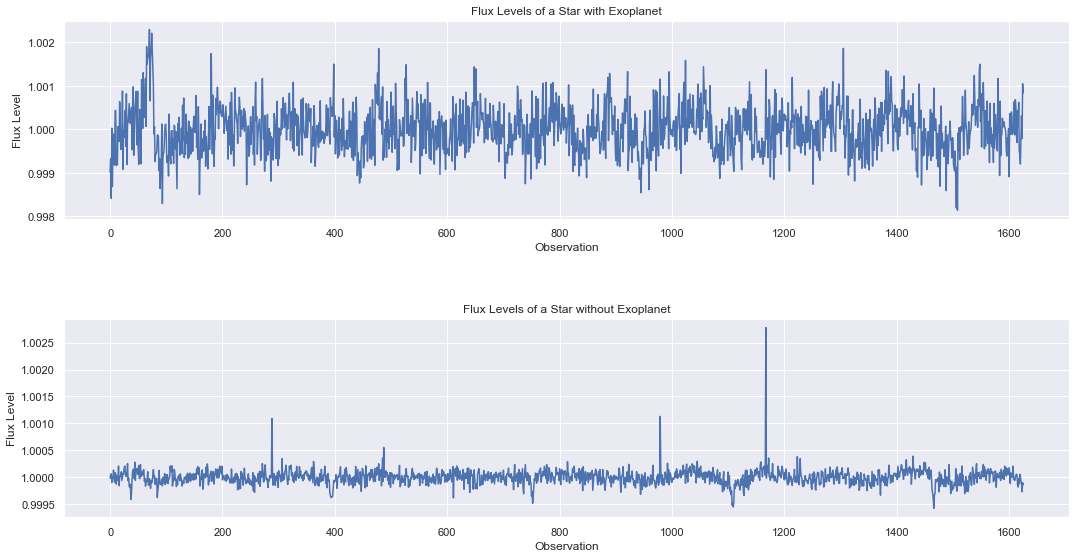

In [47]:
plt.figure(figsize=(18, 12))
# flux levels of an star with id 1
flux = df.iloc[1, 1:].values
plt.subplot(211)
plt.plot(flux)
plt.xlabel('Observation')
plt.ylabel('Flux Level')
plt.title('Flux Levels of a Star with Exoplanet')

# flux levels of an star with id 4
flux_1 = df.iloc[4, 1:].values
plt.subplot(212)
plt.plot(flux_1)
plt.xlabel('Observation')
plt.ylabel('Flux Level')
plt.title('Flux Levels of a Star without Exoplanet')

plt.subplots_adjust(hspace = .5, top = .7)
plt.show()

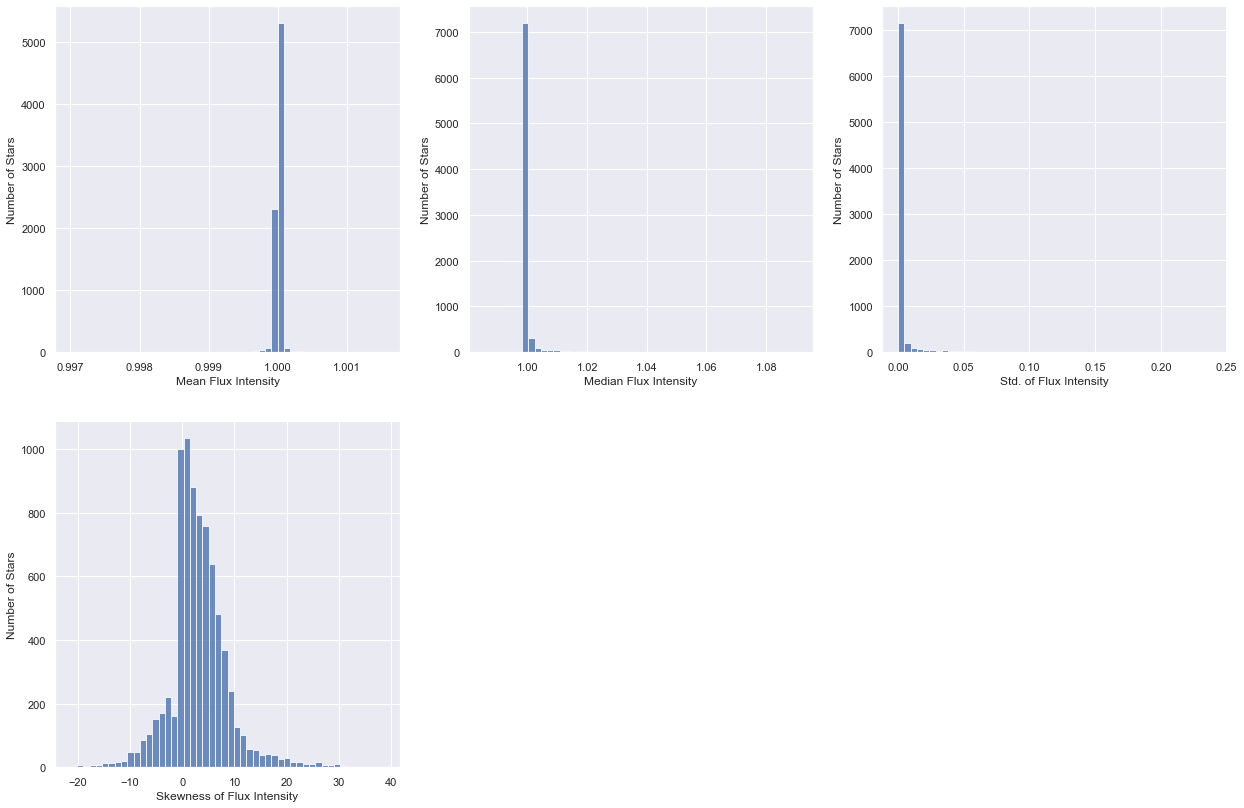

In [84]:
x = df.iloc[:, 1:]
def descriptive_statistics(x):
    means = x.mean(axis=1)
    medians = x.median(axis=1)
    stds = x.std(axis=1)
    skews = x.skew(axis=1)
    
    plt.figure(figsize=(21, 14))
    plt.subplot(231)
    plt.hist(means, alpha=.8, bins=50)
    plt.xlabel('Mean Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(232)
    plt.hist(medians, alpha=.8, bins=50)
    plt.xlabel('Median Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(233)
    plt.hist(stds, alpha=.8, bins=50)
    plt.xlabel('Std. of Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.subplot(234)
    plt.hist(skews, alpha=.8, bins=50)
    plt.xlabel('Skewness of Flux Intensity')
    plt.ylabel('Number of Stars')
    plt.show()

descriptive_statistics(x)

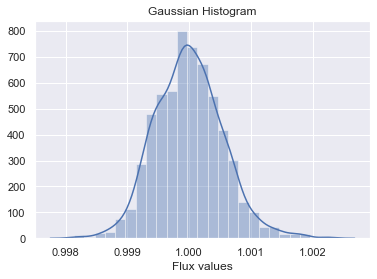

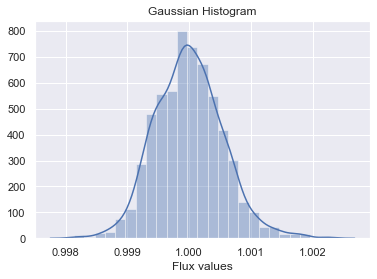

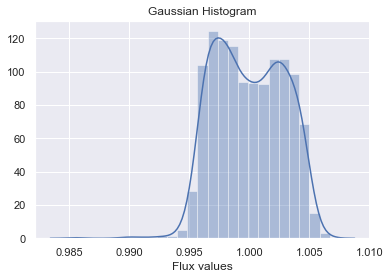

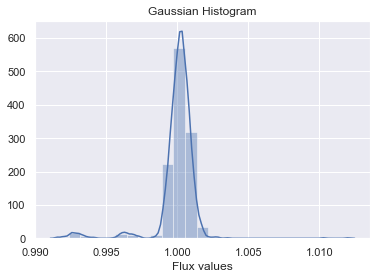

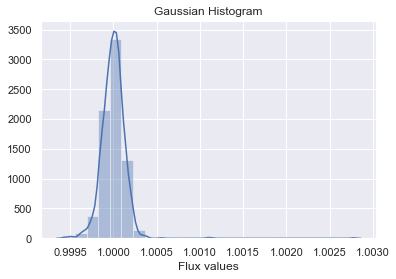

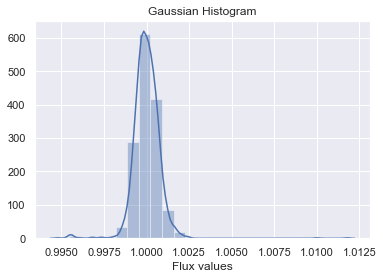

In [104]:
# Histograms of flux values for first 6 stars in the dataset.
labels=[0, 1, 2, 3, 4, 5]
for i in labels:
    sns.distplot(df.iloc[i,1:], bins=25)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [109]:
target_count = df['Disposition'].value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Percentage of Majority Class: {round(target_count[1] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[0] /sum(target_count),4)*100}')

Class 0: 3812
Class 1: 4076
Percentage of Majority Class: 51.67
Percentage of Minority Class: 48.33


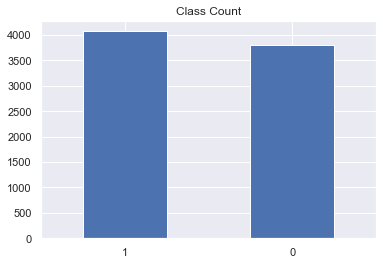

In [108]:
target_count.plot(kind='bar', title='Class Count', rot=0)

# Part 3: Feature Engineering

My dataset is time-series and not really appropriate for the classic machine learning algorithms, so I'm making my own dataset that has more characteristic features to work on.

In [5]:
target = df['Disposition']
df_values = df.iloc[:, 1:].values

In [6]:
# target values
disposition = []
for i in range(len(df)):
    disposition.append(target[i])

# median flux
medians = []
for i in range(len(df)):
    medians.append(np.median(df_values[i]))
    
# std
stds = []
for i in range(len(df)):
    stds.append(np.std(df_values[i]))

# min flux
minimum = []
for i in range(len(df)):
    minimum.append(np.amin(df_values[i]))

# max flux
maximum = []
for i in range(len(df)):
    maximum.append(np.amax(df_values[i]))

# first percentile
frst_perc = []
for i in range(len(df)):
    frst_perc.append(np.percentile(df_values[i], 1))

# third percentile
thrd_perc = []
for i in range(len(df)):
    thrd_perc.append(np.percentile(df_values[i], 3))

# fifth percentile 
fifth_perc = []
for i in range(len(df)):
    fifth_perc.append(np.percentile(df_values[i], 5))
    
# seventh percentile
seventh_perc = []
for i in range(len(df)):
    seventh_perc.append(np.percentile(df_values[i], 7))
    
# delta
delta = []
for i in range(len(df)):
    delta.append(maximum[i]-minimum[i])

In [7]:
df_reduced = pd.DataFrame({'target': target,
                           'median' : medians,
                           'standard deviation' : stds,
                           'first percentile': frst_perc,
                           'third percentile': thrd_perc,
                           'fifth percentie': fifth_perc,
                           'seventh percentile' : seventh_perc,
                           'minimum': minimum,
                           'maximum': maximum,
                           'delta': delta})

In [11]:
df_reduced.head()

,target,median,standard deviation,first percentile,third percentile,fifth percentie,seventh percentile,minimum,maximum,delta
0,1,0.999981,0.000548,0.998773,0.999048,0.999170,0.999237,0.998139,1.002296,0.004157
1,1,0.999981,0.000548,0.998773,0.999048,0.999170,0.999237,0.998139,1.002296,0.004157
2,1,0.999889,0.002861,0.994854,0.995604,0.995924,0.996116,0.985526,1.006699,0.021173
3,0,1.000215,0.001436,0.992693,0.996204,0.998810,0.999088,0.991529,1.012022,0.020493
4,0,1.000001,0.000145,0.999660,0.999757,0.999801,0.999830,0.999422,1.002780,0.003358


In [8]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target              7888 non-null   int32  
 1   median              7888 non-null   float64
 2   standard deviation  7888 non-null   float64
 3   first percentile    7888 non-null   float64
 4   third percentile    7888 non-null   float64
 5   fifth percentie     7888 non-null   float64
 6   seventh percentile  7888 non-null   float64
 7   minimum             7888 non-null   float64
 8   maximum             7888 non-null   float64
 9   delta               7888 non-null   float64
dtypes: float64(9), int32(1)
memory usage: 585.6 KB


In [9]:
df_reduced.describe()

,target,median,standard deviation,first percentile,third percentile,fifth percentie,seventh percentile,minimum,maximum,delta
count,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000,7888.000000
mean,0.516734,1.000619,0.003328,0.986599,0.991622,0.994195,0.995953,0.981881,1.009593,0.027712
std,0.499752,0.004076,0.012827,0.055837,0.042028,0.031685,0.022695,0.066814,0.013525,0.076027
min,0.000000,0.985568,0.000011,0.087550,0.172785,0.320071,0.475503,0.079371,1.000053,0.000103
25%,0.000000,0.999980,0.000272,0.998416,0.998820,0.999010,0.999127,0.997440,1.003214,0.004325
50%,1.000000,0.999993,0.000472,0.999108,0.999302,0.999402,0.999466,0.998641,1.006266,0.008300
75%,1.000000,1.000003,0.000814,0.999460,0.999573,0.999631,0.999672,0.999182,1.010936,0.014752
max,1.000000,1.090601,0.238398,0.999957,0.999962,1.000788,1.001898,0.999950,1.401710,1.091144


<Figure size 1080x504 with 0 Axes>

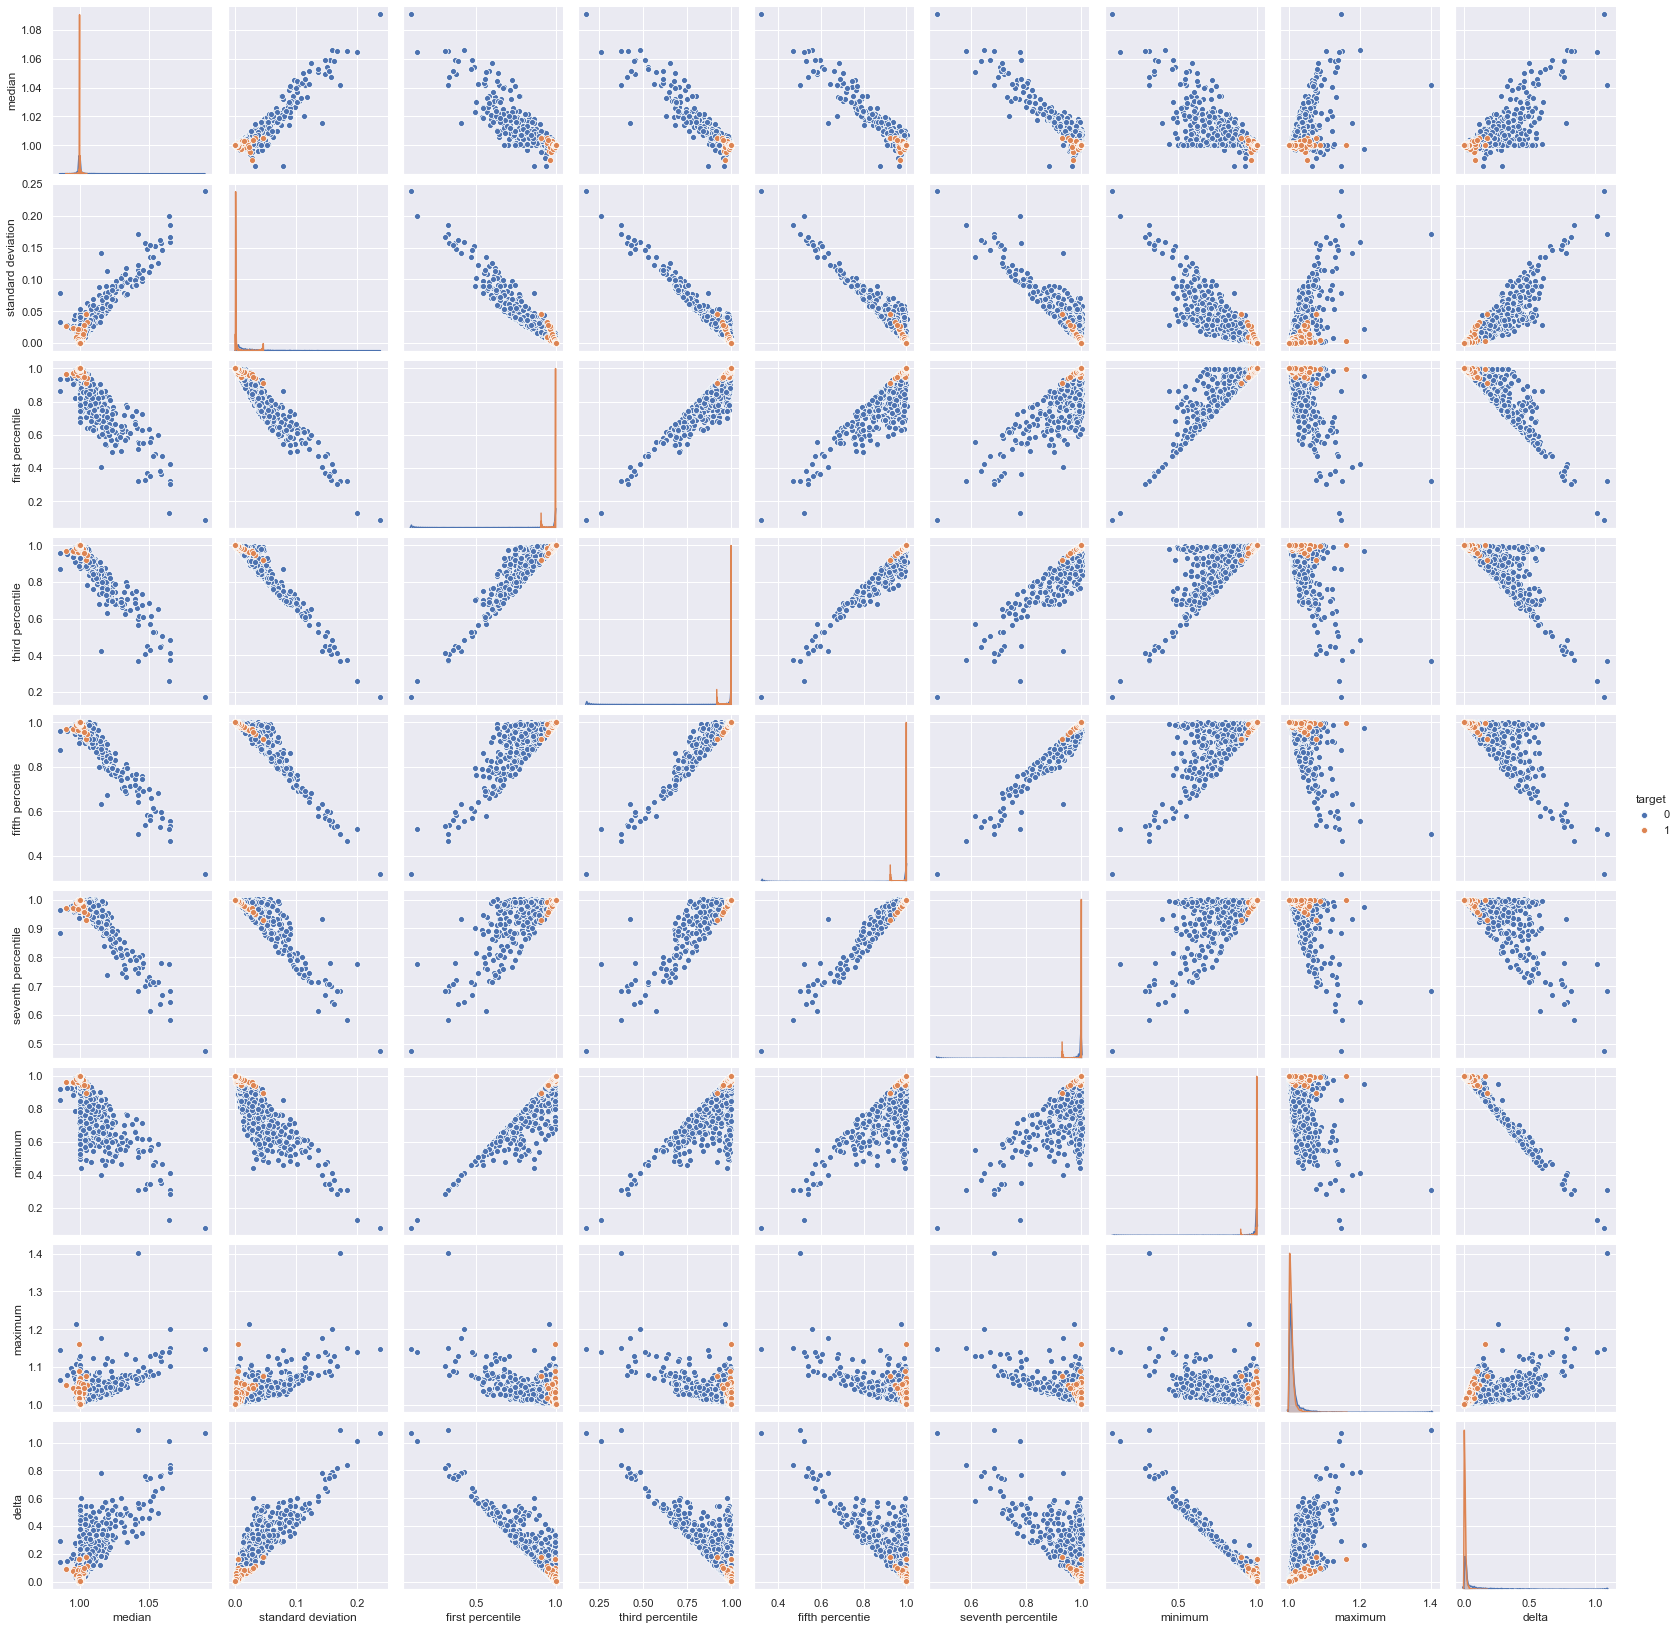

In [9]:
plt.figure(figsize = (15,7))
sns.pairplot(df_reduced, hue='target')

In [10]:
corr_mtrx=df_reduced.corr()
corr_mtrx["target"].sort_values(ascending=False)

target                1.000000
minimum               0.248197
first percentile      0.222438
third percentile      0.180693
fifth percentie       0.160971
seventh percentile    0.148838
maximum              -0.140245
median               -0.158518
standard deviation   -0.215810
delta                -0.243071
Name: target, dtype: float64

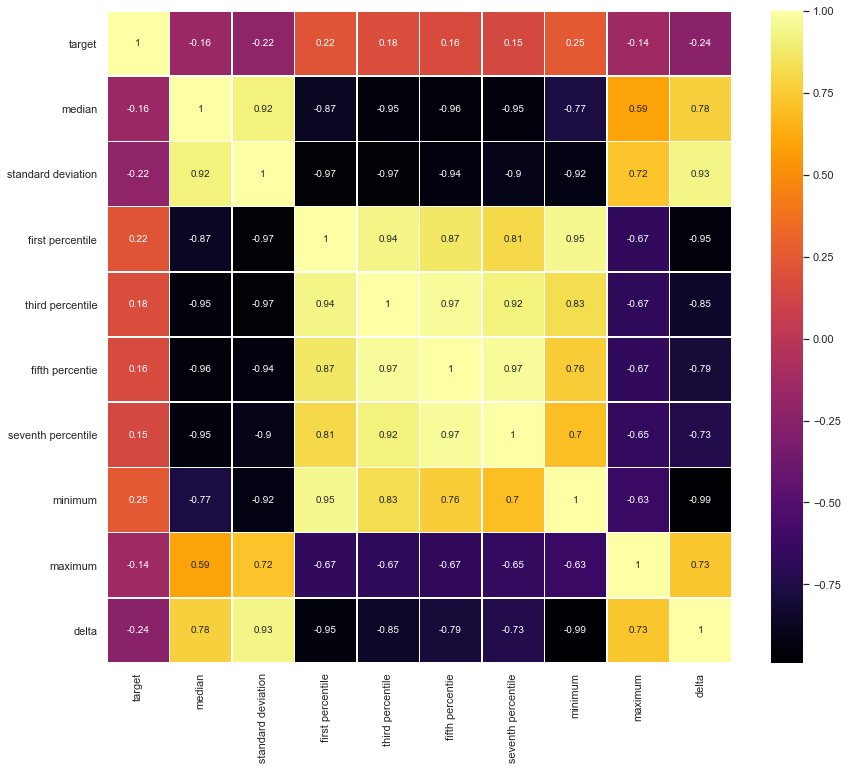

In [11]:
plt.figure(figsize = (14,12))
ax = sns.heatmap(corr_mtrx, linewidths=.5, annot=True, cmap='inferno')

In [8]:
# Basic validation: splitting the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(df_reduced.iloc[:, 1:], df_reduced.loc[:, 'target'], test_size=0.25,random_state=76)
X_train.shape # shape of my train set

(5916, 9)

In [10]:
# List to contain model and accuracy values
eva_list = []
# to contain model names
models =[]

# Part 5: ML Algorithms

## 1. Modeling on the Reduced DataFrame

### 1.1. Logistic Regression

In [9]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

lr_acc = round(lr.score(X_train, y_train) * 100, 2)
lr_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of Logistic Regression: % {lr_acc}')
print(f'Test Accuracy of Logistic Regression: % {lr_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of Logistic Regression: % 61.61
Test Accuracy of Logistic Regression: % 62.47
Precision : 0.7459057621117013
Recall : 0.6009756782657546
F1-score : 0.5462979544730978


In [12]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Logistic Regression'),
    ('Train Accuracy', round(lr_acc, 2)),
    ('Test Accuracy', round(lr_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.2. KNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_acc = round(knn.score(X_train, y_train) * 100, 2)
knn_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy of KNN: % {knn_acc}')
print(f'Test Accuracy of KNN: % {knn_acc_test}')

# Get precision, recall, and f1
precision, recall, f1, support = score(y_test, y_pred, average = 'macro')
print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F1-score : {f1}')

Train Accuracy of KNN: % 75.78
Test Accuracy of KNN: % 60.4
Precision : 0.6015623772271969
Recall : 0.6001102904728859
F1-score : 0.6000445626433646


In [14]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(knn_acc, 2)),
    ('Test Accuracy', round(knn_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.3. Naive Bayes

In [15]:
nbg = GaussianNB()
nbg.fit(X_train, y_train)
y_pred = nbg.predict(X_test)

nbg_acc=round(nbg.score(X_train, y_train) * 100, 2)
nbg_acc_test=round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of GaussianNB: % {nbg_acc}')
print(f'Test Accuracy Score of GaussianNB: % {nbg_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of GaussianNB: % 61.16
Test Accuracy Score of GaussianNB: % 61.82
Precision : 0.7463775589130098
Recall    : 0.5937489673176696
F1-score   : 0.5337582809684435


In [16]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'GaussianNB'),
    ('Train Accuracy', round(nbg_acc, 2)),
    ('Test Accuracy', round(nbg_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.4. Linear SVC

In [17]:
svc = LinearSVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)

svc_acc = round(svc.score(X_train, y_train) * 100, 2)
svc_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of LinearSVC: % {svc_acc}')
print(f'Test Accuracy Score of LinearSVC: % {svc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of LinearSVC: % 61.58
Test Accuracy Score of LinearSVC: % 62.32
Precision : 0.7333293898649644
Recall    : 0.5998004857737682
F1-score   : 0.5469824564983553


In [18]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Linear SVC'),
    ('Train Accuracy', round(svc_acc, 2)),
    ('Test Accuracy', round(svc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.5. Decision Trees

In [19]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

dt_acc = round(dt.score(X_train, y_train) * 100, 2)
dt_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Decision Trees: % {dt_acc}')
print(f'Test Accuracy Score of Decision Trees: % {dt_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Decision Trees: % 98.97
Test Accuracy Score of Decision Trees: % 62.02
Precision : 0.6182510686056786
Recall    : 0.6176183867023561
F1-score   : 0.6177597314793608


In [20]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Decision Trees'),
    ('Train Accuracy', round(dt_acc, 2)),
    ('Test Accuracy', round(dt_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [21]:
# View feature importances
importances_dt = pd.DataFrame({'feature': X_train.columns,
                             'importance': dt.feature_importances_})
importances_dt = importances_dt.sort_values('importance',ascending=False).set_index('feature')
importances_dt.head(10)

,importance
feature,
minimum,0.244407
median,0.119962
first percentile,0.110405
standard deviation,0.104137
delta,0.097372
maximum,0.093261
seventh percentile,0.087006
fifth percentie,0.077790
third percentile,0.065661


### 1.6. Random Forest

In [11]:
num_estimator = 100
seed = 7
rf = RandomForestClassifier(n_estimators=num_estimator)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rf_acc = round(rf.score(X_train, y_train) * 100, 2)
rf_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Random Forest: % {rf_acc}')
print(f'Test Accuracy Score of Random Forest: % {rf_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Random Forest: % 98.97
Test Accuracy Score of Random Forest: % 66.53
Precision : 0.6656820208533406
Recall    : 0.6596320346320346
F1-score   : 0.6593935282886141


In [23]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Random Forest'),
    ('Train Accuracy', round(rf_acc, 2)),
    ('Test Accuracy', round(rf_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

In [24]:
# View feature importances
importances_rf = pd.DataFrame({'feature': X_train.columns,
                             'importance': rf.feature_importances_})
importances_rf = importances_rf.sort_values('importance',ascending=False).set_index('feature')
importances_rf.head(10)

,importance
feature,
minimum,0.150727
standard deviation,0.121056
delta,0.117543
median,0.115849
first percentile,0.111001
maximum,0.104098
seventh percentile,0.093917
fifth percentie,0.093480
third percentile,0.092329


### 1.8. Bagging Classifier

In [25]:
bag = BaggingClassifier(base_estimator=rf, n_estimators=num_estimator,
    bootstrap=True, n_jobs=-1, random_state=seed)

bag.fit(X_train, y_train)
y_pred = bag.predict(X_test)

bag_acc = round(bag.score(X_train, y_train) * 100, 2)
bag_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Train Accuracy Score of Bagged Classifier: % {bag_acc}')
print(f'Test Accuracy Score of Bagged Classifier: % {bag_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Bagged Classifier: % 98.28
Test Accuracy Score of Bagged Classifier: % 66.89
Precision : 0.6730389485263184
Recall    : 0.6609869138495092
F1-score   : 0.6593833213906044


In [26]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Bagging Classifier'),
    ('Train Accuracy', round(bag_acc, 2)),
    ('Test Accuracy', round(bag_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

### 1.7. Stochastic Gradient Boosting Classifier

In [27]:
gbc = GradientBoostingClassifier(n_estimators=num_estimator, learning_rate=0.01,
                                random_state=seed)
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

gbc_acc = round(gbc.score(X_train, y_train) * 100, 2)
gbc_acc_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Gradient Boosting: % {gbc_acc}')
print(f'Test Accuracy Score of Gradient Boosting: % {gbc_acc_test}')

# Get precision, recall, f1 scores
precision, recall, f1, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1}')

Train Accuracy Score of Gradient Boosting: % 64.74
Test Accuracy Score of Gradient Boosting: % 64.4
Precision : 0.6983221059921986
Recall    : 0.6253800270975843
F1-score   : 0.5988036655132241


In [28]:
# Add performance parameters to list
eva_list.append(dict([
    ('Model', 'Gradient Boosting'),
    ('Train Accuracy', round(gbc_acc, 2)),
    ('Test Accuracy', round(gbc_acc_test, 2)),
    ('Precision', round(precision, 2)),
    ('Recall', round(recall, 2)),
    ('F1', round(f1, 2))
     ]))

## Evaluation - Performance List of Models 

In [29]:
results = pd.DataFrame(data=eva_list)
results = results[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
results = results.sort_values(by='Test Accuracy', ascending=False)
results = results.set_index('Model')
results

,Train Accuracy,Test Accuracy,Precision,Recall,F1
Model,,,,,
Bagging Classifier,98.28,66.89,0.67,0.66,0.66
Random Forest,98.97,65.97,0.66,0.65,0.65
Gradient Boosting,64.74,64.40,0.70,0.63,0.60
Logistic Regression,61.61,62.47,0.75,0.60,0.55
Linear SVC,61.58,62.32,0.73,0.60,0.55
Decision Trees,98.97,62.02,0.62,0.62,0.62
GaussianNB,61.16,61.82,0.75,0.59,0.53
KNN,75.78,60.40,0.60,0.60,0.60


### Optimization of the Model

I got best test accuracy on Bagging Classifier, so I go into the GridSearch with it.

In [48]:
n_est = [60, 80, 100, 120, 140, 160, 180, 200]
max_features_opt = [0.88, 0.91, 0.93, 0.95, 0.97, 0.99]

param_grid = dict(n_estimators = n_est, max_features = max_features_opt)

In [64]:
# GridSearchCV on the Bagging Classifier model to make it more robust
# Cross-validation
kf = KFold(n_splits = 10, shuffle = True, random_state = 76)
bag_grid = GridSearchCV(bag, param_grid, cv=kf, scoring='accuracy',
                      n_jobs=-1, verbose=1)
bag_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 167.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 425.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 490.6min finished


GridSearchCV(cv=KFold(n_splits=10, random_state=76, shuffle=True),
             estimator=BaggingClassifier(base_estimator=RandomForestClassifier(),
                                         n_estimators=100, n_jobs=-1,
                                         random_state=7),
             n_jobs=-1,
             param_grid={'max_features': [0.88, 0.91, 0.93, 0.95, 0.97, 0.99],
                         'n_estimators': [60, 80, 100, 120, 140, 160, 180,
                                          200]},
             scoring='accuracy', verbose=1)

In [65]:
# examine the results
print(bag_grid.best_score_)
print(bag_grid.best_params_)
print(bag_grid.best_estimator_)

0.658756584637157
{'max_features': 0.88, 'n_estimators': 180}
BaggingClassifier(base_estimator=RandomForestClassifier(), max_features=0.88,
                  n_estimators=180, n_jobs=-1, random_state=7)


In [12]:
# Optimized Bagging Classifier
opt_bag = BaggingClassifier(base_estimator=rf, n_estimators=180, max_features=0.88, 
                            bootstrap=True, random_state=seed, n_jobs = -1)

opt_bag.fit(X_train, y_train)
y_pred = opt_bag.predict(X_test)

opt_bag_acc = round(cross_val_score(opt_bag, X_train, y_train, cv=kf).mean())
opt_bag_test = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f'Train Accuracy Score of Bagging Classifier: {opt_bag_acc}')
print(f'Test Accuracy Score of Bagging Classifier: % {opt_bag_test}')

precision, recall, f1score, support = score(y_test, y_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F1-score   : {f1score}')

NameError: name 'kf' is not defined

### Confusion Matrix

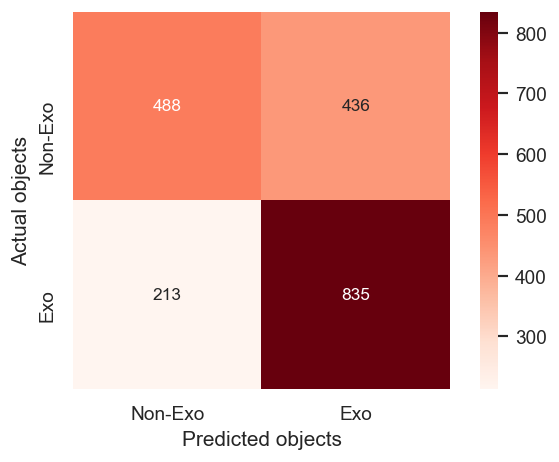

In [33]:
conf_mtrx = confusion_matrix(y_test, y_pred)
plt.figure(dpi=125)
sns.heatmap(conf_mtrx, cmap=plt.cm.Reds, annot=True, square=True,fmt='d',
           xticklabels=['Non-Exo', 'Exo'],
           yticklabels=['Non-Exo', 'Exo'])

plt.xlabel('Predicted objects')
plt.ylabel('Actual objects');

### Evaluation Graphs

ROC AUC score =  0.7447395162089818


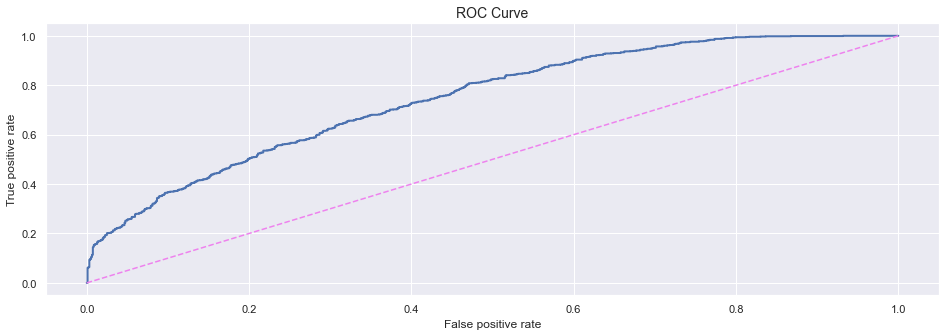

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, opt_bag.predict_proba(X_test)[:,1])

plt.figure(figsize = (16,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve', fontsize=14)
print("ROC AUC score = ", roc_auc_score(y_test, opt_bag.predict_proba(X_test)[:,1]))

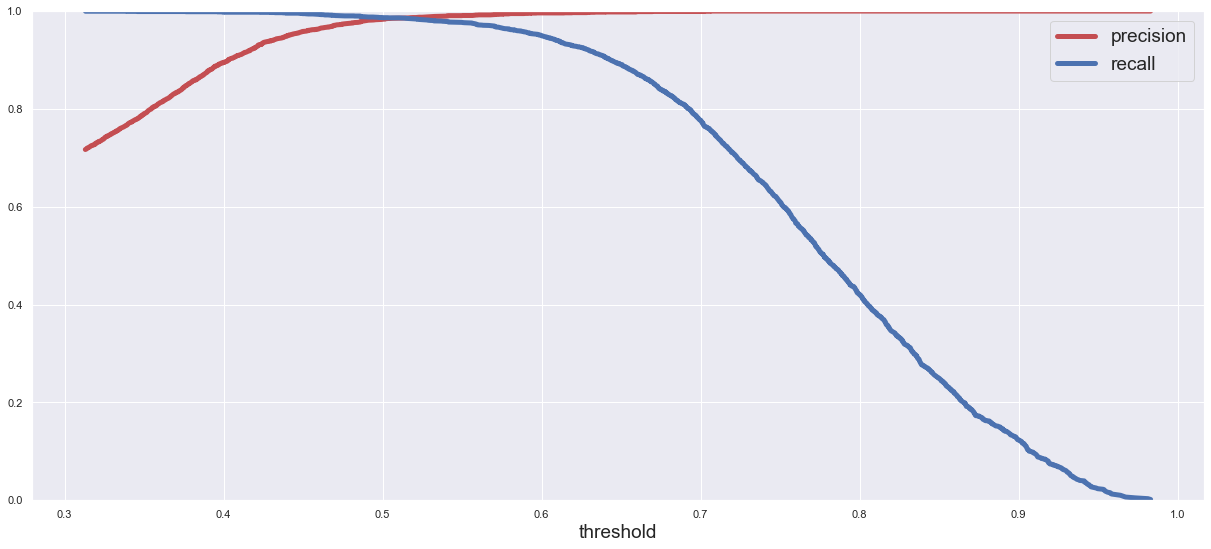

In [16]:
y_scores = opt_bag.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])
    

plt.figure(figsize = (21, 9))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

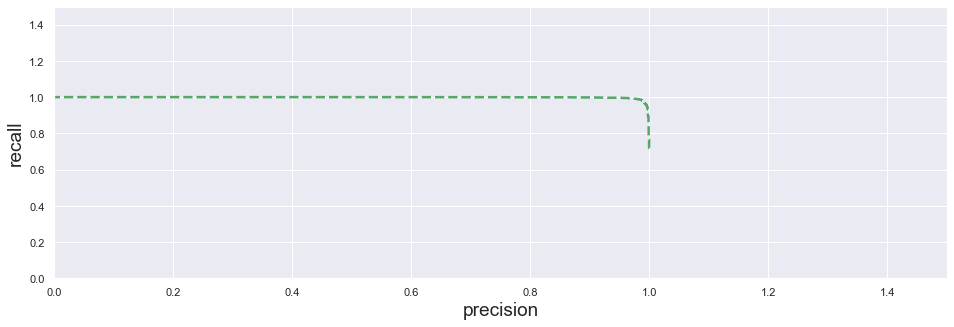

In [17]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize = (16,5))
plot_precision_vs_recall(precision, recall)
plt.show()

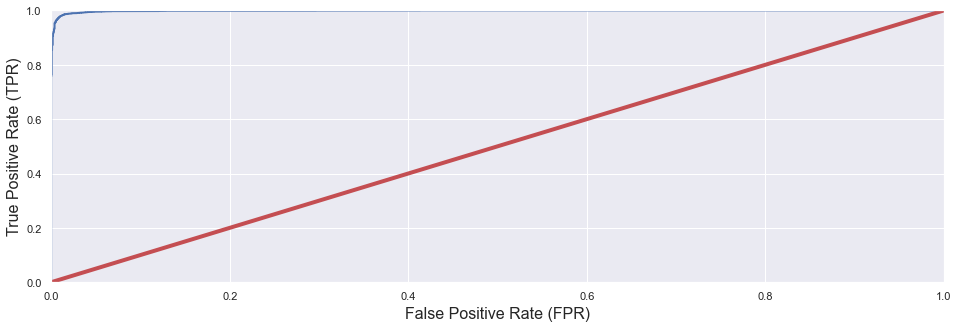

In [18]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize = (16,5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

Text(0.5, 1.0, 'Precision and Recall Curves')

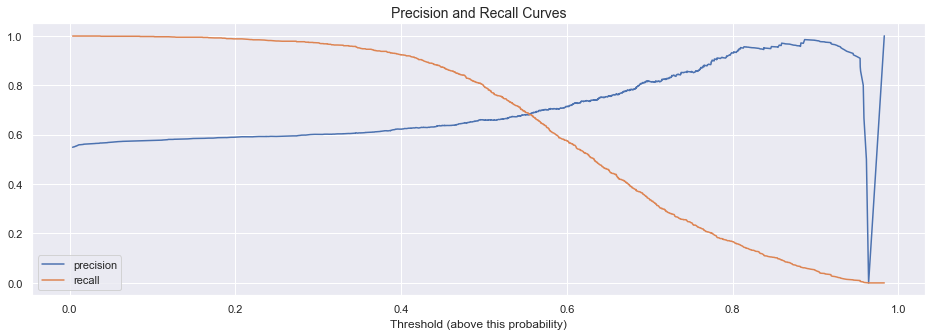

In [19]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, opt_bag.predict_proba(X_test)[:,1] )

plt.figure(figsize = (16,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability)')
plt.title('Precision and Recall Curves', fontsize=14)